# Netlift modeling

Author: Matthias Kullowatz
Version date: May 2023

## Overview

This notebook covers a popular marketing use case often referred to as "netlift" or "uplift" modeling. This modeling approach is used when you want to isolate the impact of a marketing campaign (i.e., the "treatment" or the "intervention") on specific prospective clients. That is, in fact, the key challenge in uplift modeling--to isolate the effect of the campaign--because no individual person can be observed both receiving the campaign and not receiving the campaign. Often the historical strategy for determining who receives a campaign targeted those already likely to purchase the product (or generally, produce a favorable response). That doesn't necessarily mean the campaign increased their probability of purchasing. In fact, it's possible that a campaign that targeted already high-probability buyers actually reduced their probability of purchase. These are called "sleeping dogs" in marketing terms.
<br><br>
From an ROI standpoint, increasing the probability to purchase on one group of prospects from 25% to 50% is just as valuable as increasing that probability on another group from 50% to 75% (assuming the groups are roughly the same size, with the same expected revenue values). So what you are really trying to ask machine learning models is: for which people (or groups of people) will the campaign increase the probability of purchase by the greatest amount (or generally, increase the probability of producing a favorable response). 
<br><br>
In this accelerator, you will use a generic dataset where the favorable outcome is binary: whether or not a product was purchased. The "treatment", or campaign, is simple: just one campaign type that was randomly sent to prospective buyers. You'll leverage machine learning to find patterns around the types of people for whom the campaign is most effective, controlling for their baseline likelihood to purchase even if they don't see a campaign. Uplift use cases require some additional post-processing to extract and evaluate the "uplift score", and thus this use case is an ideal candidate for leveraging the DataRobot programmatic API to seamlessly integrate powerful machine learning with one's typical coding pipeline.
<br><br>
Theoretically, the accuracy of the derived uplift scores--the increase in probability of positive outcome when the campaign is sent--relies on the assumption that the campaign was sent out randomly, uncorrelated to the features of the prospects. Thus this approach requires some sort of test campaign to be sent out randomly to prospective buyers, to generate a training dataset for uplift modeling. The example satisfies that assumption, though there is discussion at the end of an approach to work with historical data where there was some non-random selection process in who received the campaign.

### What you will learn

1. Data formatting tricks to extract the most from your uplift models.
2. How to leverage DataRobot's API to integrate powerful machine learning into your code-first pipelines.
3. How to extract uplift scores from a single binary classification model.
4. How to evaluate and understand uplift scores and their implied ROI.

## Setup

### Import libraries

The first cell of the notebook imports necessary packages.

In [1]:
from datetime import date
import random

import datarobot as dr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

As of May 5, 2023, the current Python datarobot SDK version is 3.1.0. For more information about R and Python SDK version compatibility with older, self-managed DataRobot versions, reference the DataRobot [docs](https://docs.datarobot.com/en/docs/api/index.html#self-managed-ai-platform-api-resources).

In [2]:
dr.__version__

'3.1.0'

### Connect to DataRobot

Cnnect to DataRobot through the API using a personal account token. The `config_path` should only be specified if the config file is not in the default location described in the [API Quickstart guide](https://docs.datarobot.com/en/docs/api/api-quickstart/index.html), i.e., `path-to-drconfig.yaml`. 

In [3]:
dr.Client(config_path="dr_prod_config.yaml")

## Import data

Import training and scoring (test) data from a public S3 bucket. The data contains the target: `binary response`, the indicator for having received the marketing campaign: `treatment_ind`, and many other features to help you predict the probability of a positive outcome (e.g., purchase, email response, etc.).

In [4]:
training_table = pd.read_csv(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/uplift_accelerator/training_data_100000.csv"
)
scoring_table = pd.read_csv(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/uplift_accelerator/testing_data_100000.csv"
)
training_table.head()

,ID,treatment_ind,gender,age,existing_customer_ind,customer_length_of_history,customer_num_products,highest_education,annual_income,home_owner_ind,home_value,loan_to_value,median_houshold_income_zip,binary_response,multiclass_response
0,63095,1,M,36.943533,0,0.0,0.0,Graduate,69526.330062,1.0,436636.873908,0.064747,42833.544056,0,response_0_trt_1
1,25351,1,F,57.144051,1,1.0,0.0,Bachelor,25000.000000,0.0,NaN,NaN,34873.206284,0,response_0_trt_1
2,44980,0,M,46.914507,1,2.0,2.0,HighSchool,NaN,1.0,69580.412617,0.481616,27954.744255,0,response_0_trt_0
3,18126,0,M,27.518641,0,0.0,0.0,Graduate,75300.717680,0.0,NaN,NaN,39483.484946,0,response_0_trt_0
4,23878,0,F,46.582807,1,1.0,0.0,Bachelor,25000.000000,0.0,NaN,NaN,37155.402220,0,response_0_trt_0


## Engineer interaction features

Interaction effects are when the value of two or more variables work together to influence the target. For example, a campaign might work well for one age group, but not for another. For uplift modeling, it's crucially important that you are able to detect interactions between predictor variables, the treatment indicators, and the final outcome. For this reason, derive some interactions explicitly here. While many ML algorithms built by DataRobot--such as random forests, XGBoost, and neural networks, for example--are capable of detecting interaction effects inherently, calling them out explicitly may help to pick up more signal and will likely aid in the interpretability of variable importance. 

In [5]:
# Gather features to interact with the treatment/campaign indicator
feature_list = [
    feat
    for feat in training_table.columns
    if feat not in ["ID", "treatment_ind", "binary_response", "multiclass_response"]
]

In [6]:
# Loop through features and create interactions for categorical and numeric features


def create_interactions(feature_list, training_table, treatment_col):
    for feat in feature_list:
        if training_table[feat].dtype.name == "object":
            training_table[f"{feat}_trt_int"] = [
                training_table[feat][i]
                if training_table[treatment_col][i] == 1
                else None
                for i in range(training_table.shape[0])
            ]
        elif training_table[feat].dtype.name in ["float64", "int64"]:
            training_table[f"{feat}_trt_int"] = [
                training_table[feat][i] * training_table[treatment_col][i]
                for i in range(training_table.shape[0])
            ]
    return training_table

In [7]:
# Apply the interactions function to training data
print(training_table.shape)
create_interactions(feature_list, training_table, "treatment_ind")
print(training_table.shape)
training_table.head()

(70000, 15)
(70000, 26)


,ID,treatment_ind,gender,age,existing_customer_ind,customer_length_of_history,customer_num_products,highest_education,annual_income,home_owner_ind,...,age_trt_int,existing_customer_ind_trt_int,customer_length_of_history_trt_int,customer_num_products_trt_int,highest_education_trt_int,annual_income_trt_int,home_owner_ind_trt_int,home_value_trt_int,loan_to_value_trt_int,median_houshold_income_zip_trt_int
0,63095,1,M,36.943533,0,0.0,0.0,Graduate,69526.330062,1.0,...,36.943533,0,0.0,0.0,Graduate,69526.330062,1.0,436636.873908,0.064747,42833.544056
1,25351,1,F,57.144051,1,1.0,0.0,Bachelor,25000.000000,0.0,...,57.144051,1,1.0,0.0,Bachelor,25000.000000,0.0,NaN,NaN,34873.206284
2,44980,0,M,46.914507,1,2.0,2.0,HighSchool,NaN,1.0,...,0.000000,0,0.0,0.0,None,NaN,0.0,0.000000,0.000000,0.000000
3,18126,0,M,27.518641,0,0.0,0.0,Graduate,75300.717680,0.0,...,0.000000,0,0.0,0.0,None,0.000000,0.0,NaN,NaN,0.000000
4,23878,0,F,46.582807,1,1.0,0.0,Bachelor,25000.000000,0.0,...,0.000000,0,0.0,0.0,None,0.000000,0.0,NaN,NaN,0.000000


## Modeling

### Create a project

In the binary response, single-model approach, train a model to predict the probability of the positive outcome (e.g., a purchase), using the treatment/campaign indicator as one of the features. To implement this model in productions and derive the so-called "uplift scores" for each prospect, you'll need to make two predictions per person--one assuming the campaign was received, and one assuming it was not received.

The crux of the uplift modeling question is, "who will respond favorably to the campaign and who won't?" In data science terms, those types of questions are answered by "interaction effects," described in the previous section. In a single-model approach to uplift modeling, the interactions between other features and the campaign indicator are crucial for producing meaningful uplift scores. You need the model to learn how various types of prospects respond to the campaign. With a single model, you have a few options: 

* Allow complex machine learning algorithms to uncover those interactions naturally
* Derive some of those interactions specifically to ensure that nearly any predictive model is able to calibrate those interaction effects

In [8]:
project = dr.Project.create(
    sourcedata=training_table, project_name=f"Uplift modeling {date.today()}"
)

### Create a new feature list

Inspect the feature list, choose only the features you want to model with, and create a new feature list with these features.

In [9]:
informative_features = [
    feat_list
    for feat_list in project.get_featurelists()
    if feat_list.name == "Informative Features"
][0]
informative_features.features

['treatment_ind',
 'gender',
 'age',
 'existing_customer_ind',
 'customer_length_of_history',
 'customer_num_products',
 'highest_education',
 'annual_income',
 'home_owner_ind',
 'home_value',
 'loan_to_value',
 'median_houshold_income_zip',
 'binary_response',
 'multiclass_response',
 'gender_trt_int',
 'age_trt_int',
 'existing_customer_ind_trt_int',
 'customer_length_of_history_trt_int',
 'customer_num_products_trt_int',
 'highest_education_trt_int',
 'annual_income_trt_int',
 'home_owner_ind_trt_int',
 'home_value_trt_int',
 'loan_to_value_trt_int',
 'median_houshold_income_zip_trt_int']

In [10]:
new_feature_list = project.create_featurelist(
    name="Modeling features",
    features=[
        "treatment_ind",
        "gender",
        "age",
        "existing_customer_ind",
        "customer_length_of_history",
        "customer_num_products",
        "highest_education",
        "annual_income",
        "home_owner_ind",
        "home_value",
        "loan_to_value",
        "median_houshold_income_zip",
        "gender_trt_int",
        "age_trt_int",
        "existing_customer_ind_trt_int",
        "customer_length_of_history_trt_int",
        "customer_num_products_trt_int",
        "highest_education_trt_int",
        "annual_income_trt_int",
        "home_owner_ind_trt_int",
        "home_value_trt_int",
        "loan_to_value_trt_int",
        "median_houshold_income_zip_trt_int",
    ],
)

### Start modeling

Kick off Autopilot, allowing DataRobot to test dozens of blueprints against each other to find the one that predicts purchase outcomes the best.

In [11]:
project.analyze_and_model(
    target="binary_response",
    mode="auto",
    metric=None,  # Allow DataRobot to select an objective metric
    worker_count=-1,  # Select max number of workers
    positive_class=1,
    featurelist_id=new_feature_list.id,
)

Project(Uplift modeling 2023-05-31)

In [12]:
# Pause the interpreter to wait for Autopilot to complete
project.wait_for_autopilot()

In progress: 31, queued: 0 (waited: 0s)
In progress: 31, queued: 0 (waited: 1s)
In progress: 31, queued: 0 (waited: 2s)
In progress: 31, queued: 0 (waited: 3s)
In progress: 31, queued: 0 (waited: 4s)
In progress: 31, queued: 0 (waited: 7s)
In progress: 31, queued: 0 (waited: 11s)
In progress: 31, queued: 0 (waited: 18s)
In progress: 30, queued: 0 (waited: 31s)
In progress: 19, queued: 0 (waited: 52s)
In progress: 14, queued: 0 (waited: 73s)
In progress: 14, queued: 0 (waited: 94s)
In progress: 13, queued: 0 (waited: 114s)
In progress: 13, queued: 0 (waited: 135s)
In progress: 13, queued: 0 (waited: 156s)
In progress: 11, queued: 0 (waited: 177s)
In progress: 5, queued: 0 (waited: 197s)
In progress: 2, queued: 0 (waited: 218s)
In progress: 1, queued: 0 (waited: 239s)
In progress: 1, queued: 0 (waited: 260s)
In progress: 16, queued: 0 (waited: 280s)
In progress: 16, queued: 0 (waited: 301s)
In progress: 10, queued: 0 (waited: 322s)
In progress: 3, queued: 0 (waited: 343s)
In progress: 3,

### Make predictions

You can leverage the API to submit a scoring dataset with new prospects, and retrieve predictions for each one. For the binary classification approach to uplift modeling, you need to submit duplicate rows for every observation: one assuming they received the campaign and one assuming they didn't. This is what helps you to isolate the impact of the campaign on each new prospect. Create a duplicate row for each original observation, in which you flip flop the campaign indicator so that each individual will be in the dataset once with the campaign and once without. By inlcuding the "duplicated" column, you can later easily identify which subset is the original. 

In [13]:
# Duplicate rows for every prospect, with the opposite campaign indicator
opposite_treatment_ind = [
    1 - og_trt_ind for og_trt_ind in scoring_table["treatment_ind"]
]
duplicate_rows = scoring_table.copy()
duplicate_rows["treatment_ind"] = opposite_treatment_ind
duplicate_rows["duplicated"] = 1
scoring_table["duplicated"] = 0
scoring_table = pd.concat([scoring_table, duplicate_rows], axis=0, ignore_index=True)
scoring_table.head()

,ID,treatment_ind,gender,age,existing_customer_ind,customer_length_of_history,customer_num_products,highest_education,annual_income,home_owner_ind,home_value,loan_to_value,median_houshold_income_zip,binary_response,multiclass_response,duplicated
0,4,0,F,44.218347,1,0.0,1.0,Graduate,151807.278575,1.0,7753.191661,0.525477,49890.178855,0,response_0_trt_0,0
1,6,1,F,41.277469,0,0.0,0.0,SomeCollege,25000.000000,0.0,NaN,NaN,42493.393459,0,response_0_trt_1,0
2,7,0,F,50.048116,1,5.0,0.0,Graduate,250446.318717,1.0,430072.573642,0.518393,52452.826216,0,response_0_trt_0,0
3,10,1,F,41.791368,1,1.0,3.0,Bachelor,208941.674781,1.0,381994.506441,0.087626,69603.220884,0,response_0_trt_1,0
4,14,0,F,50.340704,1,1.0,0.0,NaN,36408.728313,0.0,NaN,NaN,33482.343950,0,response_0_trt_0,0


Use the `create_interactions()` function, created above, to loop through features and create interactions in your "new" scoring dataset. It's important to do this after setting the campaign indicator for the duplicated rows above, so that all interactions are derived according to the "new" treatment/campaign indicator. 

In [14]:
print(scoring_table.shape)
create_interactions(feature_list, scoring_table, "treatment_ind")
print(scoring_table.shape)

(60000, 16)
(60000, 27)


In [15]:
# Identify the top-performing model
top_model = project.recommended_model()

In [16]:
# Submit the scoring job and retrieve predictions
dr_dataset = project.upload_dataset(scoring_table)
dr_scoring_job = top_model.request_predictions(dataset_id=dr_dataset.id)
predictions = dr_scoring_job.get_result_when_complete()
predictions.head()

,row_id,prediction,positive_probability,prediction_threshold,class_0.0,class_1
0,0,0.0,0.011375,0.5,0.988625,0.011375
1,1,0.0,0.165773,0.5,0.834227,0.165773
2,2,0.0,0.018745,0.5,0.981255,0.018745
3,3,0.0,0.224094,0.5,0.775906,0.224094
4,4,0.0,0.011357,0.5,0.988643,0.011357


### Post-processing

Now that you have two predictions for each individual--one assuming they received the treatment/campaign and one assuming they didn't--you can derive the uplift score. The uplift score is the increase in probability of a purchase (i.e., positive outcome) due to the campaign.

In [17]:
# Join the predictions back onto the scoring table
scoring_table = pd.concat(
    [scoring_table, predictions[["positive_probability"]]], axis=1
)

In [18]:
# Pivot the two probabilities into a wide format for each prospect
scoring_table_flat = pd.pivot(
    scoring_table, index="ID", columns="treatment_ind", values="positive_probability"
).reset_index()
scoring_table_flat.columns = ["ID", "prob_trt_0", "prob_trt_1"]
scoring_table_flat["uplift"] = (
    scoring_table_flat["prob_trt_1"] - scoring_table_flat["prob_trt_0"]
)
scoring_table_uplift = pd.merge(
    scoring_table.loc[scoring_table["duplicated"] == 0],
    scoring_table_flat,
    how="left",
    on="ID",
)
print(scoring_table_uplift.shape)
scoring_table_uplift[
    ["ID", "treatment_ind", "prob_trt_0", "prob_trt_1", "uplift"]
].head()

(30000, 31)


,ID,treatment_ind,prob_trt_0,prob_trt_1,uplift
0,4,0,0.011375,0.075989,0.064614
1,6,1,0.019001,0.165773,0.146771
2,7,0,0.018745,0.155609,0.136864
3,10,1,0.017584,0.224094,0.206510
4,14,0,0.011357,0.045558,0.034201


Sorting by uplift score shows you the prospects with the most potential to increase probability of a sale due to receiving the campaign. 

In [19]:
scoring_table_uplift[
    ["ID", "treatment_ind", "prob_trt_0", "prob_trt_1", "uplift"]
].sort_values(["uplift"], ascending=False).head()

,ID,treatment_ind,prob_trt_0,prob_trt_1,uplift
19289,63921,1,0.133799,0.817159,0.683360
7404,24309,1,0.064405,0.712315,0.647910
15432,50884,0,0.137139,0.774809,0.637670
15717,51817,1,0.111698,0.739795,0.628097
16835,55482,1,0.155039,0.771261,0.616222


## Model evaluation

Model evaluation for uplift looks different than for more typical predictive modeling problems. Uplift scores are generated using hypotheticals (i.e., what if George had actually received the campaign) and you don't have actual results for half of the predictions that went into uplift scores.
<br><br>

### Lift charts

First, you can still do typical model evaluation on the underlying binary classification model. When looking at these lift charts, you want that model to be able to produce a usable range of predictions, and to match actual results closely for low predictions, high predictions and all predictions in between. Additionally, you might want to confirm that the fit is good across a particular feature. First review the resuable functions to download lift chart data from DataRobot and reproduce the plots you see in the GUI. 

In [20]:
import matplotlib.pyplot as plt

# Increase the font
plt.rcParams.update({"font.size": 12})


def prepare_lift_chart_data(
    preds: pd.DataFrame, bin_feature: str, n_bins: int = 10
) -> pd.DataFrame:
    """
    This function aggregates data into specified bins for easier plotting.

    Parameters
    ----------
    preds: dataframe consisting of a columns "predicted" and "actual" representing the predicted and target values, respectively
    bin_feature: which feature should be grouped and plotted along the x-axis
    n_bins: how many groups to use for splitting the data

    Returns
    ----------
    Dataframe containing aggregated data needed to create DataRobot's lift chart
    """

    # First define the bins based on the predictions
    preds = preds.copy()
    preds["bins"] = pd.qcut(
        preds[bin_feature], q=n_bins, labels=np.arange(1, n_bins + 1, 1), retbins=False
    ).values

    # Aggregate
    plot_data = (
        preds.groupby("bins")
        .agg(
            actual=("actual", "mean"),
            predicted=("predicted", "mean"),
            bin_weight=("bins", "size"),
            predicted_std=("predicted", "std"),
            x_mean=(bin_feature, "mean"),
        )
        .reset_index(drop=True)
    )

    return plot_data


def generate_dr_lift_chart(plot_data: pd.DataFrame, bin_feature: str, title: str = ""):
    """
    This function creates a lift chart with a similar color scheme as DataRobot's GUI.

    Parameters
    ----------
    plot_data: output of the function "prepare_lift_chart_data()"
    title: what to use for the chart's title
    """

    # Color scheme
    predicted_color = "#1F77B4"
    actual_color = "#FF7F0E"
    background_color = "black"

    # Defining bins
    if "x_mean" in plot_data.columns:
        bin_labels = plot_data.x_mean
    else:
        bin_labels = plot_data.predicted

    # Initialize
    fig, ax = plt.subplots(figsize=(20, 7))

    # Plots
    ax.plot(
        bin_labels,
        plot_data["actual"],
        lw=2,
        color=actual_color,
        marker="o",
        markersize=8,
        markerfacecolor="none",
        markeredgewidth=2,
        label="Actual",
    )
    ax.plot(
        bin_labels,
        plot_data["predicted"],
        lw=2,
        color=predicted_color,
        marker="+",
        markersize=8,
        markeredgewidth=2,
        label="Predicted",
    )

    # Settings
    ax.set_facecolor(background_color)
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel(bin_feature + " mean value")
    ax.set_ylabel("Average target value")
    ax.grid(visible=True, color="gray", linewidth=0.25)
    plt.margins(0.025)  # to reduce white space

    # To ensure the xticks aren't too crowded
    if plot_data.shape[0] <= 60:
        if "x_mean" in plot_data.columns:
            plt.xticks(
                np.arange(
                    np.min(plot_data.x_mean),
                    np.max(plot_data.x_mean),
                    (np.max(plot_data.x_mean) - np.min(plot_data.x_mean)) / 10,
                )
            )
        else:
            plt.xticks(
                np.arange(
                    np.min(plot_data.predicted),
                    np.max(plot_data.predicted),
                    (np.max(plot_data.predicted) - np.min(plot_data.predicted)) / 10,
                )
            )

    plt.title(title)
    plt.show()

Extract both the lift chart's binned data and the raw predictions from DataRobot on the cross-validation partitions. This represents two ways to get the lift chart data and create the lift chart. You can further highlight that by extracting the raw predictions, and you have more flexibility to create specific actual-vs-predicted charts in addition to the conventional lift chart. 

In [21]:
# Fetch the cross validation predictions
training_predictions_job = top_model.request_training_predictions(
    dr.enums.DATA_SUBSET.ALL
)
training_predictions = (
    training_predictions_job.get_result_when_complete().get_all_as_dataframe()
)
training_predictions = training_predictions.loc[
    training_predictions["partition_id"] != "Holdout"
]

In [22]:
# Join training data onto cross-validated predictions
cv_preds_with_data = (
    training_predictions.set_index("row_id")
    .join(training_table)
    .rename(columns={"class_1.0": "predicted", "binary_response": "actual"})
    .drop("partition_id", axis=1)
    .reset_index()
)
cv_preds_with_data[["ID", "treatment_ind", "predicted", "actual"]].head()

,ID,treatment_ind,predicted,actual
0,25351,1,0.124611,0
1,44980,0,0.008873,0
2,18126,0,0.017726,0
3,27866,0,0.018369,0
4,38522,0,0.021056,0


In [23]:
# Segment data into bins, ordered by the predicted probability
lift_chart_data = prepare_lift_chart_data(
    preds=cv_preds_with_data, bin_feature="predicted", n_bins=60
)
lift_chart_data.head()

,actual,predicted,bin_weight,predicted_std,x_mean
0,0.005353,0.005374,934,0.000447,0.005374
1,0.003215,0.006274,933,0.000195,0.006274
2,0.005359,0.006918,933,0.000183,0.006918
3,0.009636,0.007532,934,0.000169,0.007532
4,0.007503,0.008083,933,0.000150,0.008083


In [24]:
# Verify the above with the bins DataRobot automatically created
dr_lift_chart_data = pd.DataFrame(
    top_model.get_lift_chart(source=dr.enums.CHART_DATA_SOURCE.CROSSVALIDATION).bins
)
dr_lift_chart_data.head()

,actual,predicted,bin_weight
0,0.005353,0.005374,934.0
1,0.003215,0.006274,933.0
2,0.005359,0.006918,933.0
3,0.009636,0.007532,934.0
4,0.007503,0.008083,933.0


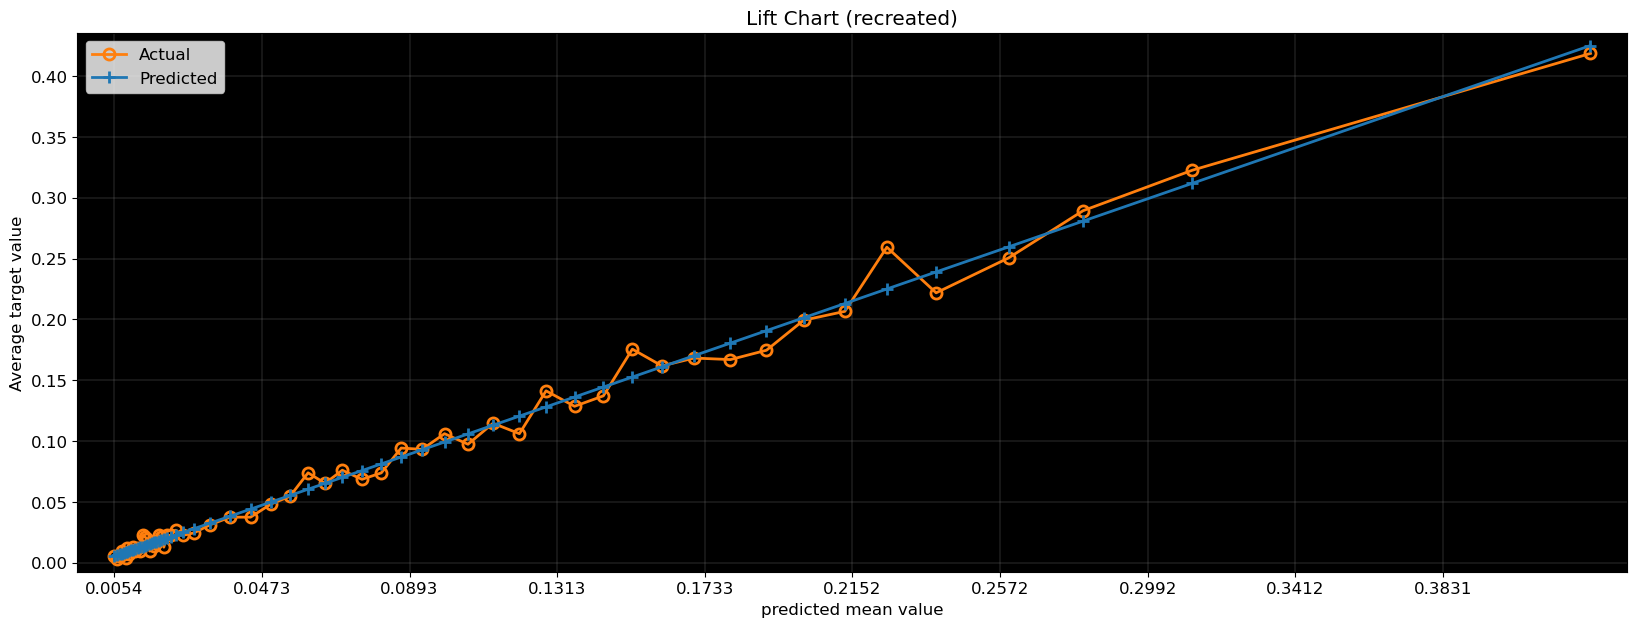

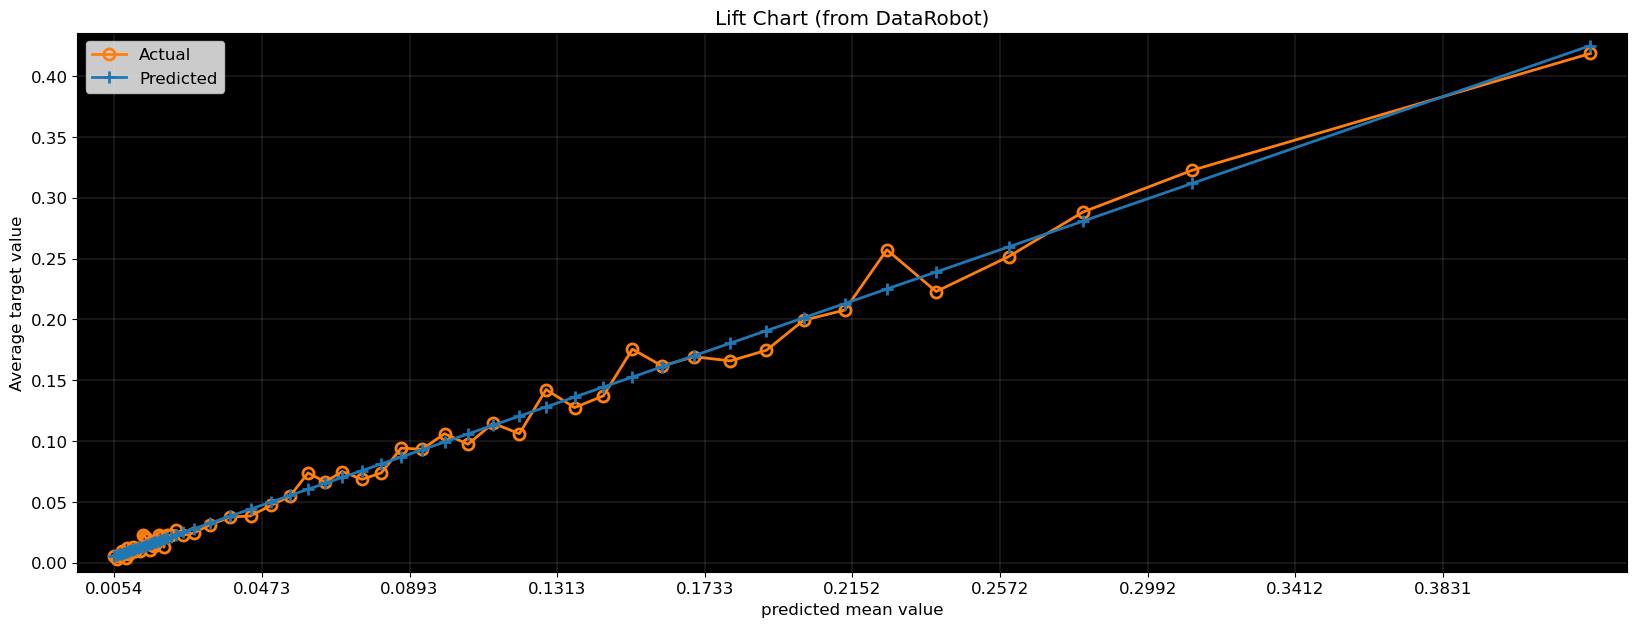

In [25]:
# Plot both and confirm they are the same
generate_dr_lift_chart(
    plot_data=lift_chart_data, bin_feature="predicted", title="Lift Chart (recreated)"
)
generate_dr_lift_chart(
    plot_data=dr_lift_chart_data,
    bin_feature="predicted",
    title="Lift Chart (from DataRobot)",
)

Lets now look at actual-vs-predicted purchase rates across home value, a feature that is important in the next section. 

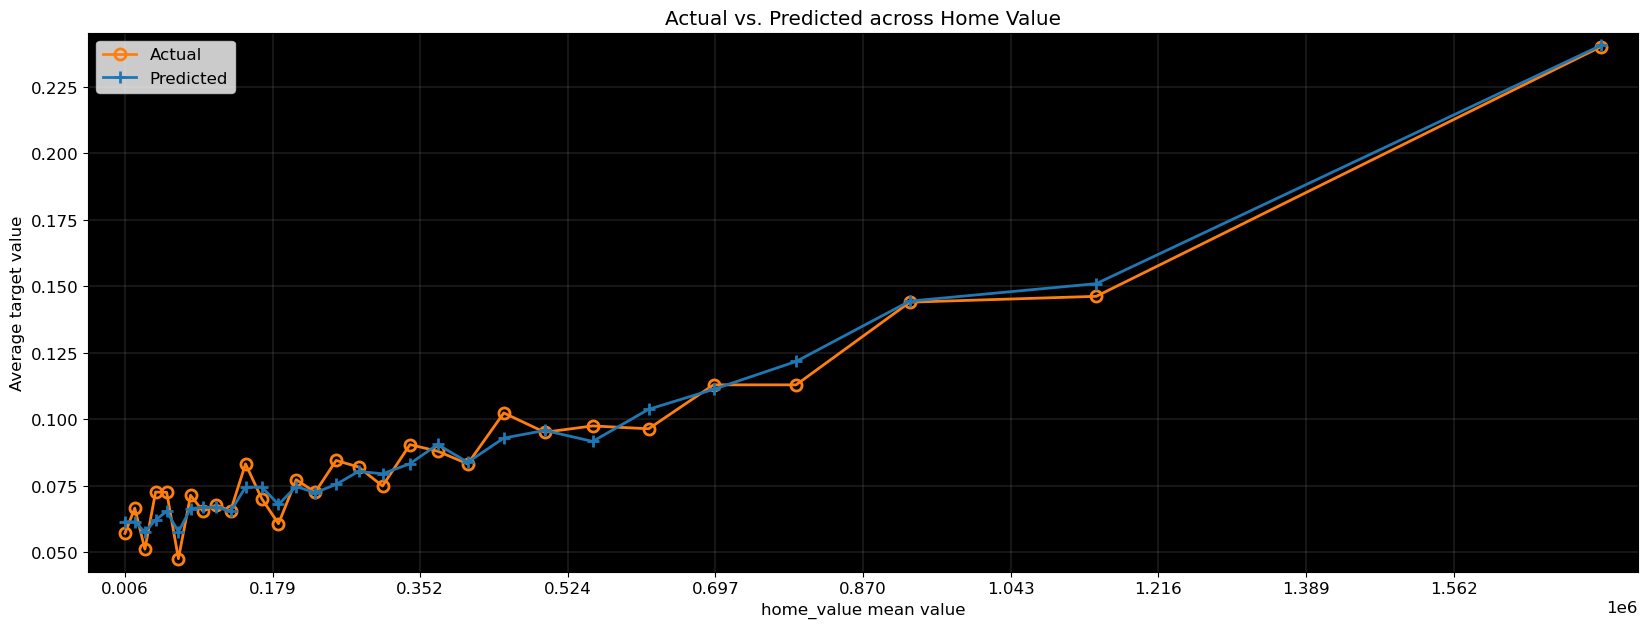

In [26]:
home_values_a_vs_p = prepare_lift_chart_data(
    preds=cv_preds_with_data, bin_feature="home_value", n_bins=30
)
generate_dr_lift_chart(
    plot_data=home_values_a_vs_p,
    bin_feature="home_value",
    title="Actual vs. Predicted across Home Value",
)

## Uplift reasonablity and ROI intuition

Two approaches to evaluating the <i>reasonability</i> of the uplift scores, as discussed in [this paper](https://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf), include Uplift Decile Charts and Cumulative Uplift Gain. Again, you can't directly measure uplift, so you can't directly measure uplift accuracy, but you can still get comfortable with the models. 
<br><br>
View an example of the the Uplift Decile Charts below, which involve splitting up the testing set across those that actually received the campaign and those that did not. For each subset, bucket the observations by the uplift score from least to greatest (e.g., into deciles), and then finally compare the average predictions for correponding buckets between those treated and those not treated. As Gutierrez, et al., describe, this gives us an idea of the uplift gain per decile. 

In [27]:
# Segment test data into treatment and control groups
# Bucket into deciles by the uplift scores
treated = scoring_table_uplift.loc[scoring_table_uplift["treatment_ind"] == 1].copy()
treated["uplift_ntile"] = pd.qcut(treated["uplift"], q=10, labels=range(1, 10 + 1))

control = scoring_table_uplift.loc[scoring_table_uplift["treatment_ind"] == 0].copy()
control["uplift_ntile"] = pd.qcut(control["uplift"], q=10, labels=range(1, 10 + 1))

# Group by decile and summarize average predictions
treated_grouped = (
    treated.groupby(["uplift_ntile"])
    .agg(avg_pred=("prob_trt_1", "mean"), avg_uplift=("uplift", "mean"))
    .reset_index()
)

control_grouped = (
    control.groupby(["uplift_ntile"])
    .agg(avg_pred=("prob_trt_0", "mean"), avg_uplift=("uplift", "mean"))
    .reset_index()
)

# Calculate differences between the average predictions of corresponding deciles
# This probability difference is like "grouped uplift"
grouped_data = pd.merge(
    treated_grouped,
    control_grouped,
    how="left",
    on="uplift_ntile",
    suffixes=("_trt", "_ctrl"),
)
grouped_data["prob_diff"] = grouped_data["avg_pred_trt"] - grouped_data["avg_pred_ctrl"]
grouped_data

,uplift_ntile,avg_pred_trt,avg_uplift_trt,avg_pred_ctrl,avg_uplift_ctrl,prob_diff
0,1,0.045717,0.035417,0.010156,0.035304,0.035561
1,2,0.063701,0.054012,0.009887,0.054566,0.053814
2,3,0.080749,0.069937,0.010826,0.070941,0.069924
3,4,0.098462,0.086454,0.012399,0.087862,0.086063
4,5,0.119178,0.105426,0.014373,0.106269,0.104805
5,6,0.143683,0.127245,0.016201,0.127787,0.127482
6,7,0.169644,0.152080,0.018175,0.152640,0.151469
7,8,0.200906,0.181629,0.019614,0.182366,0.181292
8,9,0.240162,0.218513,0.021810,0.220407,0.218352
9,10,0.338668,0.303787,0.033069,0.298343,0.305599


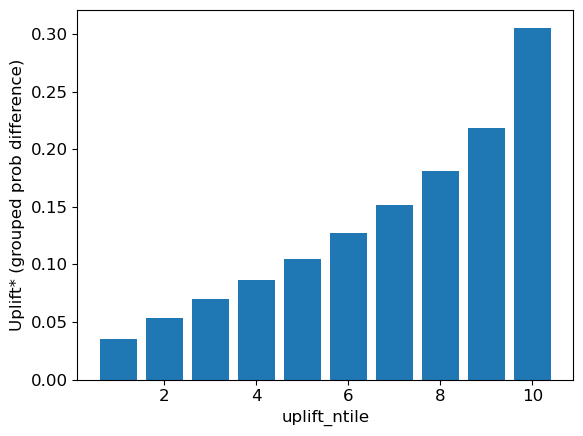

In [28]:
# Plot the probability differences across the deciles
plt.bar(grouped_data["uplift_ntile"], grouped_data["prob_diff"])
plt.xlabel("uplift_ntile")
plt.ylabel("Uplift* (grouped prob difference)")
plt.show()

To better understand this chart, focus on the left-most bucket. That bucket is telling you that the observed prospects in the lowest 10% of uplift among those who <i>did</i> receive the campaign are only about 4% more likely to purchase than the lowest 10% among those who <i>did not</i> receive the campaign. Conversely, when comparing the top 10% groups, the expected uplift is 30%. If the campaign had been adminstered optimally in the past, you might expect this chart to be flatter. But this tells us there is something to be gained by targeting a more optimal group for the campaign. 

## Model understanding

### Feature Impact

Feature Impact shows on which features the model is relying most (and least) to make its predictions. 

In [29]:
import seaborn as sns

feature_impact = pd.DataFrame(top_model.get_or_request_feature_impact(max_wait=3600))

<Axes: xlabel='featureName', ylabel='impactNormalized'>

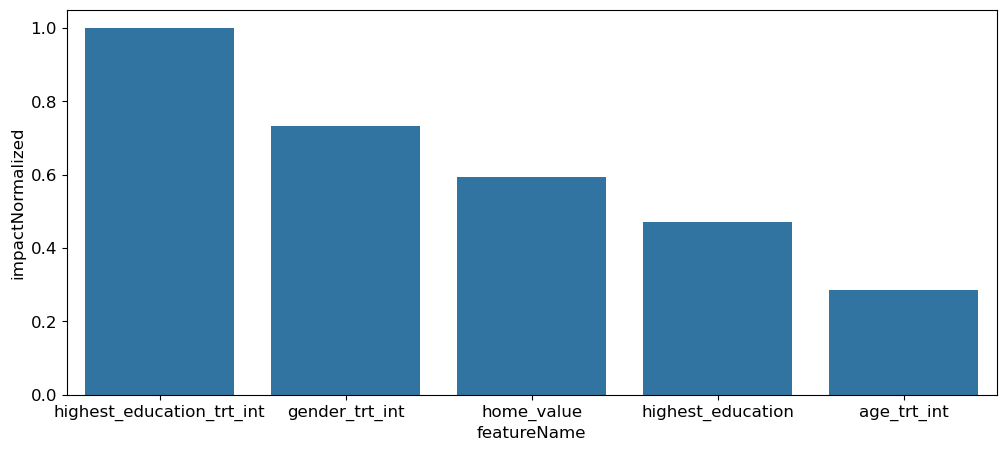

In [30]:
fig, ax = plt.subplots(figsize=(12, 5))

# Plot feature impact
sns.barplot(
    x="featureName", y="impactNormalized", data=feature_impact[0:5], color="#1F77B4"
)

### Feature effects

Feature effects, or partial dependence, show us the relationship between the predictor variables and the target variable, while holding all other variables constant.

In [31]:
# Request that DataRobot calculate feature effects for your top-performing model
feature_effects = top_model.request_feature_effect()
feature_effects.wait_for_completion()  # Wait until feature effects compute

In [32]:
# Define a function to plot feature effects


def plot_partial_dependence_column(feature_effects, column, is_numeric=True):
    temp_pd = list(feature_effects.get_result())
    for item in temp_pd:
        if item["feature_name"] == column:
            partial_dependence_data = item["partial_dependence"]["data"]
            partial_dependence_data_df = pd.DataFrame(
                partial_dependence_data
            )  # Save results into a pandas dataframe
            partial_dependence_data_df.columns = ["value", "target_probability"]
    if is_numeric:
        partial_dependence_data_df.loc[
            partial_dependence_data_df["value"] == "nan", "value"
        ] = None
        partial_dependence_data_df["value"] = pd.to_numeric(
            partial_dependence_data_df["value"]
        )

    plt.figure(figsize=(16, 6))

    ax = sns.lineplot(
        x="value",
        y="target_probability",
        data=partial_dependence_data_df,
        color="#1F77B4",
    )
    ax.set_title(f"Feature effects ({column})")
    if is_numeric:
        plt.xticks(
            np.arange(
                np.min(partial_dependence_data_df.value),
                np.max(partial_dependence_data_df.value),
                (
                    np.max(partial_dependence_data_df.value)
                    - np.min(partial_dependence_data_df.value)
                )
                / 10,
            )
        )

    return partial_dependence_data_df

,value,target_probability
0,1.033150e+04,0.064142
1,1.363540e+04,0.064316
2,1.659441e+04,0.063996
3,2.005424e+04,0.063144
4,2.335042e+04,0.063809
...,...,...
95,1.058620e+06,0.143810
96,1.132003e+06,0.151182
97,1.227442e+06,0.159336
98,1.349921e+06,0.173358


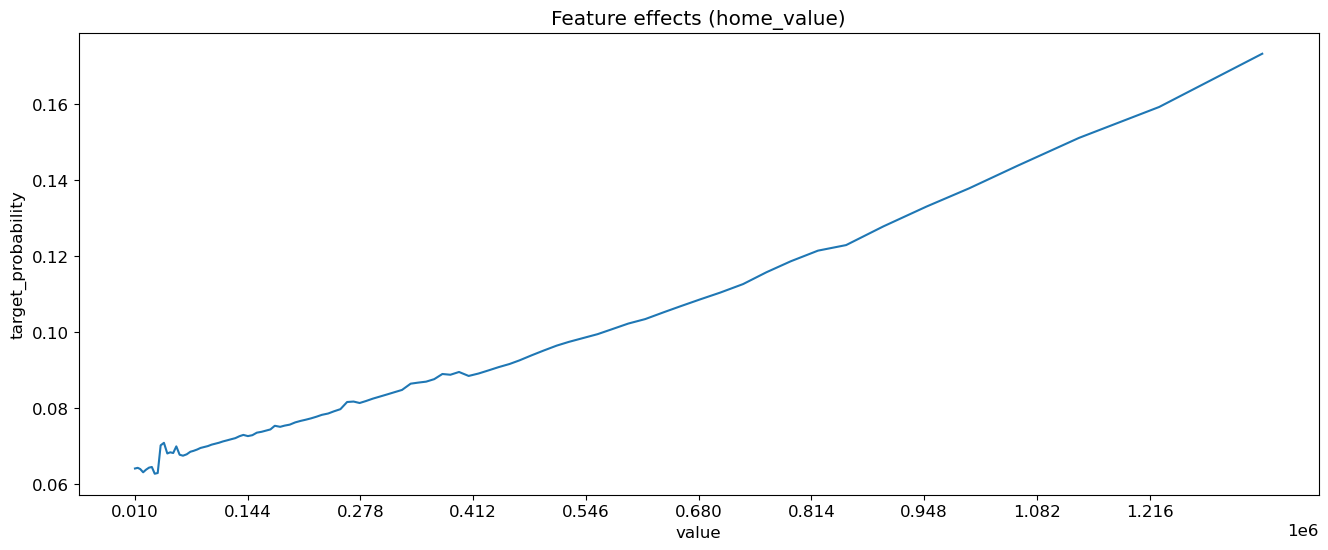

In [33]:
# Produce the feature effects plot
plot_partial_dependence_column(feature_effects, "home_value")  # Fill in your own column

### Prediction explanations

Prediction explanations tell you which features impacted each observation's predictions, and relatively by how much. One usage of these explanations for uplift modeling is to compare the top features for the same individual, with and without the campaign, to show what makes this type of prospect tick.

In [34]:
# Initiate prediction explanations for model
pred_exp_init = dr.PredictionExplanationsInitialization.create(project.id, top_model.id)
pred_exp_init.wait_for_completion()

In [35]:
# Upload a dataset to be scored for a particular prospect ID
prospect_ID = (
    scoring_table_uplift.sort_values(by=["uplift"], ascending=False).reset_index().ID[0]
)
prospect_df = scoring_table.loc[scoring_table["ID"] == prospect_ID]
scoring_dataset_dr = project.upload_dataset(prospect_df)
prospect_df[["ID", "treatment_ind"]].head()

,ID,treatment_ind
19289,63921,1
49289,63921,0


In [36]:
# Create the prediction explanations scoring job
pred_job = top_model.request_predictions(scoring_dataset_dr.id)
pred = pred_job.get_result_when_complete()

# Extract the prediction explanations
pred_exp_job = dr.PredictionExplanations.create(
    project.id, top_model.id, scoring_dataset_dr.id
)
pred_exp = pred_exp_job.get_result_when_complete().get_all_as_dataframe()
columns = [c for c in pred_exp.columns if ("_feature" in c) | ("qualitative" in c)]
pred_exp[["class_1_probability"] + columns].head()

,class_1_probability,explanation_0_feature,explanation_0_feature_value,explanation_0_qualitative_strength,explanation_1_feature,explanation_1_feature_value,explanation_1_qualitative_strength,explanation_2_feature,explanation_2_feature_value,explanation_2_qualitative_strength
0,0.817159,home_value,2.047087e+06,+++,highest_education_trt_int,Bachelor,++,gender_trt_int,M,++
1,0.133799,home_value,2.047087e+06,+++,highest_education_trt_int,,--,gender_trt_int,,--


When this individual received the campaign, the model estimated that it would increase their probability of purchase by nearly 70%, from 13.4% to 81.7%. That's a huge uplift. In the training dataset, prospects purchased about 8% of the time. So this individual was already relatively more likely than average to purchase. But that clearly doesn't mean you shouldn't campaign to them. You sometimes can get the most lift from groups already likely to purchase, especially in cases where the average likelihood of purchase is relatively low. What drove these predictions? 
<br><br>
Their probability of purchase was relatively high, regardless of the campaign, because their home value was more than $2,000,000. Additionally, their traits that interacted strongly with the campaign (labeled `trt_int`) were their education level and gender. Males with bachelor's degrees appear to respond strongly to the campaign. 

## Measure ROI

Here you evaluate whether the uplift scores you generated imply a potential to further optimize the campaign. The Uplift Decile Chart above seemed to suggest that you could. Recall that you preserved an external holdout set with actual target outcomes, and you'll leverage that here with one approach.

1. Determine the value returned on a sale (or positive response), and the cost of the campaign. For simplicity, let's start with assumptions that the campaign costs one unit per prospect, and a sale has a net return of ten units. Realistically, the net return value would likely be a function of the expected value of the sale, which may come from a preliminary ML model.
2. Derive the actual profit of the campaign, as it was delivered to prospects in the external holdout. Profit here is measured as the total gains of sales minus the total costs of the campaign.
3. Identify an optimal uplift threshold to maximize profit, where campaigns are only sent to those with a positive expected value.

### Actual profit

The actual, realized profit was 9,251 units, and the model's expected profit was 10,057 units, assuming the implementation of the campaign that actually happened. These should be reasonably close if the model is doing well. Note that the positive profit here does <i>not</i> mean that the campaign "worked" necessarily--as the product being sold could be profitable regardless of advertising or campaigning--but it does give a baseline to try to beat with a better campaign selection process.

In [37]:
# Derive realized profit under the actual, observed campaign
print(
    np.array(
        10 * scoring_table_uplift["binary_response"]
        - 1 * scoring_table_uplift["treatment_ind"]
    ).sum()
)

# Derive the models expected/predicted profit under the actual, observed campaign
probs_orig = [
    scoring_table_uplift["prob_trt_1"][i]
    if scoring_table_uplift["treatment_ind"][i] == 1
    else scoring_table_uplift["prob_trt_0"][i]
    for i in range(len(scoring_table_uplift))
]
print(
    (
        10 * np.array(probs_orig) - 1 * np.array(scoring_table_uplift["treatment_ind"])
    ).sum()
)

9251
10057.1753468288


You can also determine the expected profit if you didn't campaign to anyone. The expected profit in that case is 4,993 units, which is lower than the actual and expected profits for the existing campaign selection methodology. This suggests that the campaign as is did help increase profits, but can the selection process be improved?

In [38]:
probs_notrt = scoring_table_uplift["prob_trt_0"]
np.sum(10 * np.array(probs_notrt))

4993.1264255855685

### Optimizing expected profit, measuring potential ROI
For a simple problem like this, with constant costs and benefits per prospect, you can easily derive an optimal threshold. You know the campaign costs one unit, and a sale would get us ten units. That means the campaign has to increase the probability of purchase by at least 10% to break even `(10% x 10 - 1 = 0)`. Therefore you should campaign to all prospects with uplift scores of at least 10%. 
<br><br>
To apply this optimal threshold and derive expected profit, in the calculation you need to use the appropriate probability of purchase for each individual in the holdout dataset (recall that each person has two purcahse probabilities, one with and one without the campaign). You also need to subract the cost of the campaign only for those individuals who will be receiving it in this hypothetical. This maximizes expected profit at 19,656 units.

In [39]:
# Determine hypothetical campaign recipients, based on given threshold
threshold = 0.10
probs_const_thresh = [
    scoring_table_uplift["prob_trt_1"][i]
    if scoring_table_uplift["uplift"][i] > threshold
    else scoring_table_uplift["prob_trt_0"][i]
    for i in range(len(scoring_table_uplift))
]

# Calculate total profit under this scenario
(
    10 * np.array(probs_const_thresh)
    - 1
    * np.array(
        [
            1 if scoring_table_uplift["uplift"][i] > threshold else 0
            for i in range(len(scoring_table_uplift))
        ]
    )
).sum()

19655.726188239856

Typical problems are more complicated, with campaign costs and purchase revenues unique to each prospect. In those cases, the decision to campaign should be derived from the individual prospects' expected returns from the campaign. For example, if a particular prospect costs two units to campaign to, but returns only an expected five units with a sale, then the break-even point is an uplift score of 40% (40% x 5 - 2 = 0). More generally, the breakeven probability is cost/revenue. The cells below generate random costs and benefits per prospect to articulate the individualized approach. 

In [40]:
# Generate unique revenues randomly for illustration
random.seed(a=314, version=2)
revenues = random.choices(range(5, 16), k=len(scoring_table_uplift))
costs = random.choices(range(1, 5), k=len(scoring_table_uplift))
# Determine individual break even point for each prospect
break_even = [costs[i] / revenues[i] for i in range(len(scoring_table_uplift))]

In [41]:
# Profit, assuming no campaign (repeat of above)
profit_notrt = np.sum(10 * np.array(probs_notrt))
profit_notrt

4993.1264255855685

In [42]:
# Profit, assuming original campaign selection (probs_orig from above)
profit_orig = (
    np.array(revenues) * np.array(probs_orig)
    - np.array(costs)
    * np.array(
        [
            1 if scoring_table_uplift["treatment_ind"][i] == 1 else 0
            for i in range(len(scoring_table_uplift))
        ]
    )
).sum()
profit_orig

-12606.444267643401

In [43]:
# Profit, assuming optimal campaign selection
probs_optimal = [
    scoring_table_uplift["prob_trt_1"][i]
    if scoring_table_uplift["uplift"][i] > break_even[i]
    else scoring_table_uplift["prob_trt_0"][i]
    for i in range(len(scoring_table_uplift))
]
profit_optimal = (
    np.array(revenues) * np.array(probs_optimal)
    - np.array(costs)
    * np.array(
        [
            1 if scoring_table_uplift["uplift"][i] > break_even[i] else 0
            for i in range(len(scoring_table_uplift))
        ]
    )
).sum()
profit_optimal

10576.264120559119

Using these individual costs and benefits per prospect, showed above that the original campaign selection would have generated negative profit (-12,606 units), and no campaign would have generated 4,990 units of profit. The optimal approach increases profit to 10,576 units. This is summarized below in the bar chart.

<Axes: xlabel='Campaign', ylabel='Profit'>

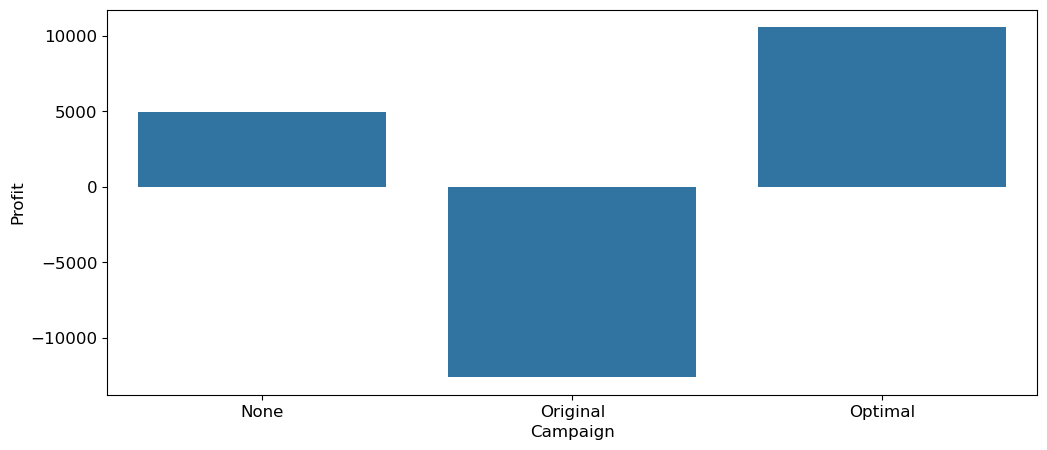

In [44]:
fig, ax = plt.subplots(figsize=(12, 5))
profit_df = pd.DataFrame(
    {
        "Campaign": ["None", "Original", "Optimal"],
        "Profit": [profit_notrt, profit_orig, profit_optimal],
    }
)
sns.barplot(x="Campaign", y="Profit", data=profit_df, color="#1F77B4")

## Conclusion

### When training data has campaign selection bias

As discussed briefly in the introduction, often times the only historical data available for modeling was biased, in that recipients of the campaign were selected based on their features. An extreme example of this phenomenon helps to show the potential issues with this bias: consider a simple campaign strategy and dataset, where everyone with brown hair received the campaign and everyone with blonde hair did not. Whatever the results, the effect of the campaign and the effect of hair color will be completely inseparable. If the treatment/brown-hair group converts at a rate 20% greater than the control/blonde-hair group, there is no way to know if it was the hair color or the campaign that drove the increased probability of purchase. A machine learning model will essentially credit random fractions of the estimated 20% effect to hair color and to the campaign. But in reality, the entirety of the 20% difference could be due to the campaign, and not the hair color at all.
<br><br>
You don't often see such extreme examples. Rather, the approach that was implemented to select campaign recipients includes some randomness and some ability to compare brunettes to blondes. What that means in terms of the example is that some brown-haired people will not have received the campaign, and some blonde-haired people will have received it. This gives machine learning a chance to jump in and potentially account for hair color and campaign receipt simultaneously, controlling for each other. This is where you can try some clever sampling. 
<br><br>
One approach is referred to as Propensity Score Matching, and there is an existing DataRobot example [here](https://www.datarobot.com/blog/welcome-to-conducting-quasi-experiments-with-datarobot/) for reference. Essentially, first you build a model on the historical data to predict whether someone would be selected <i>to receive the campaign/treatment</i>. This helps to explain the process that was used historically to make that selection. Then you use the output probability from that model to control your training sample, focusing on pairs of individuals with similar likelihoods to receive the campaign. That's "(campaign) propensity score matching". 

In a machine learning approach, you could sample your training data down to only those individuals with similar probabilities of being selected for the campaign, say between 45% and 55%. While this is still not a truly random sample, it helps to control for selection bias in the uplift modeling approach described in this notebook. Alternatively you could include that probability in your propensity <i>to buy</i> model, or leave it out and rely on the machine learning algorithms and the presence of <i>some</i> randomness in campaign selection to pick apart and isolate the campaign effect.

### Utilizing DataRobot's Bias and Fairness functionality

[Bias and fairness](https://docs.datarobot.com/en/docs/modeling/special-workflows/b-and-f/index.html) in DataRobot refers to a suite of tools that can (1) assess how the model may be biased toward or against subsamples of the training data, and (2) take action to mitigate those biases. Often it is used to ensure fairness in AI/ML models for protected classes, but the tool can be used more generally, as well. In this case, you may want to test the model for certain biases between those who received the campaign and those who did not. There are multiple fairness metrics that can be tested, and versions of [prediction accuracy](https://docs.datarobot.com/en/docs/modeling/special-workflows/b-and-f/bias-ref.html#favorable-predictive-value-parity), for example may help highlight whether the model is relatively struggling with one of the two treatment groups.  